Scratch Jupyter Noteboook

In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import nonlinear_approximator as na
from importlib import reload
import torch
import torchvision
import PIL
%matplotlib inline
from dask.distributed import Client, LocalCluster
import dask
import dask.array as da

Dask Client for Distributed Computation 

# Load and Plot MNIST Dataset 

In [2]:
def one_hot_ten(int_label: torch.Tensor) -> NDArray[np.floating]:
    oh = np.zeros((10,))
    oh[int_label] = 1
    return oh

def to_numpy_arr(img: PIL.Image) -> NDArray[np.floating]:
    # rescale 255 to +/- 1 
    arr = np.asarray(img).flatten()
    arr = arr / 255 # 0 --> 1
    arr = arr - .5  # -.5 --> .5
    arr = 2 * arr   # -1 --> 1
    return arr
    
    


In [3]:
train_data = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=to_numpy_arr, target_transform=one_hot_ten)
test_data = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=to_numpy_arr, target_transform=one_hot_ten)

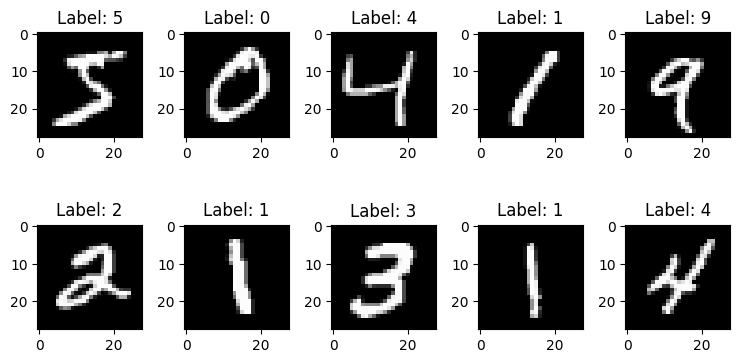

In [4]:
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5*num_cols,2*num_rows))
for i in range(num_rows*num_cols):
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(train_data[i][0].reshape((28, 28)), cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(train_data[i][1])))
plt.tight_layout()
plt.show()

# Parameters

In [ ]:
reload(na)
reload(na.model)
reload(na.activations)
reload(na.params)
reload(na.training)

config = na.params.RegressionParams(
    width=100,
    depth=50,
    input_dimension=len(train_data[0][0]),
    transform_type=na.activations.TransformType.TENT,
    transform_params=na.params.TentParams(mu=1.99),
    output_dimension=len(train_data[0][1]),
    batch_size=1000,
)


# Instantiate Model

In [6]:
model = na.model.NonlinearRegressorModel(config)
imgs_train, labels_train = zip(*train_data)
imgs_train = da.array(imgs_train).persist()
labels_train = da.array(labels_train).persist()


imgs_test, labels_test = zip(*test_data)
imgs_test = da.array(imgs_test).persist()
labels_test = da.array(labels_test).persist()

print(f"Loaded training data images with shape {imgs_train.shape}, and labels with shape {labels_train.shape}")
print(f"Loaded test data images with shape {imgs_test.shape}, and labels with shape {labels_test.shape}")


/home/fritz/untitled/.venv/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 358.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Loaded training data images with shape (60000, 784), and labels with shape (60000, 10)
Loaded test data images with shape (10000, 784), and labels with shape (10000, 10)


/home/fritz/untitled/.venv/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 59.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [7]:
help(model._dask_client)

Help on Client in module distributed.client object:

class Client(distributed.utils.SyncMethodMixin)
 |  Client(address=None, loop=None, timeout=<no_default>, set_as_default=True, scheduler_file=None, security=None, asynchronous=False, name=None, heartbeat_interval=None, serializers=None, deserializers=None, extensions={}, direct_to_workers=None, connection_limit=512, **kwargs)
 |  
 |  Connect to and submit computation to a Dask cluster
 |  
 |  The Client connects users to a Dask cluster.  It provides an asynchronous
 |  user interface around functions and futures.  This class resembles
 |  executors in ``concurrent.futures`` but also allows ``Future`` objects
 |  within ``submit/map`` calls.  When a Client is instantiated it takes over
 |  all ``dask.compute`` and ``dask.persist`` calls by default.
 |  
 |  It is also common to create a Client without specifying the scheduler
 |  address , like ``Client()``.  In this case the Client creates a
 |  :class:`LocalCluster` in the backgro

# Train MNIST Classifier

In [ ]:
model.fit(imgs_train[:1000, :], labels_train[:1000, :])

In [ ]:
import dask.multiprocessing as dm
import dask.array as da
def hello(arg):
    return [1]
with dm.multiprocessing.Pool(15) as p:
    decoders = da.stack(
        *[
            p.starmap(
                func=hello,
                iterable= [
                    (
                        '1'
                    )
                    for idx_neuron in range(100)
                ],
            ),
        ],
        axis=-1,
    )


decoders.compute()

In [ ]:
from functools import partial
from nonlinear_approximator.inference import infer
import h5py
from nonlinear_approximator.model import NonlinearRegressorModel
def predict(self, input_x: NDArray[np.floating], average: bool=True) -> NDArray[np.floating]:
    
    if not self.config.storage_path: # in memory mode 
        if self.decoders is None:
            raise RuntimeError("The provided model has not been trained so cannot make a prediction. Call 'fit' first or 'load' first.")
        
        outputs = infer(input_x, self.neurons, self.decoders, self.config)
        
        if average: 
            return outputs.mean(axis=2).T
        else:
            return outputs
    else: # use persistent storage
        self._check_storage_path_configured()
        with h5py.File(self.config.storage_path.resolve().absolute(), 'a') as file:
            input_dim, num_samples = input_x.shape
            # use a recursive average to accumulate outputs from multiple chunks of neurons so we don't load all into memory at once 
            output_avg = None
            count_avg = 0
            
            for neuron_chunk in file[NonlinearRegressorModel.DECODER_STRPATH].iter_chunks():
                print(f"neuron chunk: {neuron_chunk}; count_avg: {count_avg}")            
                # get neural activations for this batch of data                         
                slice_start = neuron_chunk[2].start
                slice_end = self.config.width if not hasattr(neuron_chunk[2], 'end') else neuron_chunk[2].end
                
                if np.any(np.isnan(
                    file[NonlinearRegressorModel.DECODER_STRPATH][neuron_chunk]
                )):
                    raise ValueError(f"Recorded Decoders for slice {neuron_chunk} contained NaN values: {file[NonlinearRegressorModel.DECODER_STRPATH][neuron_chunk]}")
                
                output = infer(
                    input_x, 
                    self.neurons[:, slice_start:slice_end], 
                    file[NonlinearRegressorModel.DECODER_STRPATH][neuron_chunk], 
                    self.config
                ).mean(axis=2).T
                
                count = slice_end - slice_start + 1

                if count_avg == 0:
                    output_avg = output
                    count_avg = count
                
                else:
                    output_avg = (output * count + output_avg * count_avg) / (count + count_avg)
                    count_avg += count 
                    
            return output_avg.T
model.predict = partial(predict, model)
probs_train = model.predict(imgs_train[:,:1000])

In [ ]:
probs_train

In [ ]:
preds_train = probs_train.T.argmax(axis=1)
print(preds_train.shape)
acc_train = sum(preds_train==labels_train.argmax(axis=0)[:1000]).T / len(preds_train)

plt.hist(preds_train, bins=10)
plt.hist(labels_train.argmax(axis=0)[:1000], bins=10, alpha=0.3)
plt.title(f"Histogram of model predicted classifications on training data. Accuracy = {100 *acc_train}%")
plt.xlabel("Digit")
plt.ylabel(f"Number of classifciations (N={len(preds_train)})")
plt.show()


In [ ]:
probs_test = model.predict(imgs_train[:,:1000]) 
preds_test = probs_test.T.argmax(axis=0)
acc_test = sum(preds_test==labels_test.argmax(axis=0)[:1000]) / len(preds_test)

plt.hist(preds_test, bins=10)
plt.hist(labels_test.argmax(axis=0)[:1000], bins=10, alpha=0.3)
plt.title(f"Histogram of model predicted classifications on test data. Accuracy = {100 *acc_test}%")
plt.xlabel("Digit")
plt.ylabel(f"Number of classifciations (N={len(preds_test)})")
plt.show()

In [ ]:
xor_thresh = 0.5

xors_train_rounded = outputs.mean(axis=2).copy()
xors_train_rounded[xors_train_rounded <= xor_thresh] = 0
xors_train_rounded[xors_train_rounded > xor_thresh] = 1
xor_train_actual = np.array(
    [xor(train_samples[:, i]) for i in range(train_samples.shape[1])]
)


mask_0 = np.isclose(xors_train_rounded, 0).squeeze()
mask_1 = np.isclose(xors_train_rounded, 1).squeeze()
plt.scatter(
    train_samples[0, mask_0],
    train_samples[1, mask_0],
    c="red",
    marker="x",
    label="XOR = 0",
)
plt.scatter(
    train_samples[0, mask_1],
    train_samples[1, mask_1],
    c="green",
    marker="o",
    label="XOR = 1",
)

mask_incorrect = (xors_train_rounded != xor_train_actual).squeeze()
plt.scatter(
    train_samples[0, mask_incorrect],
    train_samples[1, mask_incorrect],
    marker="+",
    c="yellow",
)

plt.axis("equal")
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")

plt.title(
    f"Network Approximation of XOR function  (Applied to Training Data)\nAccuracy = {100 * (1 - sum(mask_incorrect) / num_samples_train)}%"
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()


# Test XOR Approximation

In [ ]:
outputs_test = infer(test_samples, neurons, decoders, config)
#  (D x S) x (D x Y).T @ (D x S) ==> Y x
plt.hist(outputs_test.mean(axis=2).T, 20, density=True)
plt.title(f"Test Eval Output Probability Histogram N={test_samples.shape[1]}")
plt.xlabel("P(XOR Evals to True)")
plt.show()

In [ ]:
xor_thresh = 0.5

xors_test_rounded = outputs_test.mean(axis=2).copy()
xors_test_rounded[xors_test_rounded <= xor_thresh] = 0
xors_test_rounded[xors_test_rounded > xor_thresh] = 1
xors_test_actual = np.array(
    [xor(test_samples[:, i]) for i in range(test_samples.shape[1])]
)


mask_0 = np.isclose(xors_test_rounded, 0).squeeze()
mask_1 = np.isclose(xors_test_rounded, 1).squeeze()
plt.scatter(
    test_samples[0, mask_0],
    test_samples[1, mask_0],
    c="red",
    marker="x",
    label="XOR = 0",
)
plt.scatter(
    test_samples[0, mask_1],
    test_samples[1, mask_1],
    c="green",
    marker="o",
    label="XOR = 1",
)

mask_incorrect = (xors_test_rounded != xors_test_actual).squeeze()
plt.scatter(
    test_samples[0, mask_incorrect],
    test_samples[1, mask_incorrect],
    marker="+",
    c="yellow",
)

plt.axis("equal")
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")

plt.title(
    f"Network Approximation of XOR function  (Applied to Test Data)\nAccuracy = {100 * (1 - sum(mask_incorrect) / num_samples_train)}%"
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()